In [1]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# PyTorch
import torch
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool, global_max_pool, global_add_pool
import torch.nn.functional as F

# sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# cust_functions folder
from cust_functions.training import *
from cust_functions.graph_networks import *
from cust_functions.graph_creation import *

# Set random seed
SEED = 42
set_seed(SEED)

## 1.0 Graph creation

### 1.1 Biological pathway graph


Number of nodes:  2585
Number of edges:  2603
Number of nodes with no edges:  0
Mean number of edges per node:  2.0
Max number of edges per node:  72
Min number of edges per node:  1
Median number of edges per node:  1.0
Number of nodes without proteins:  424


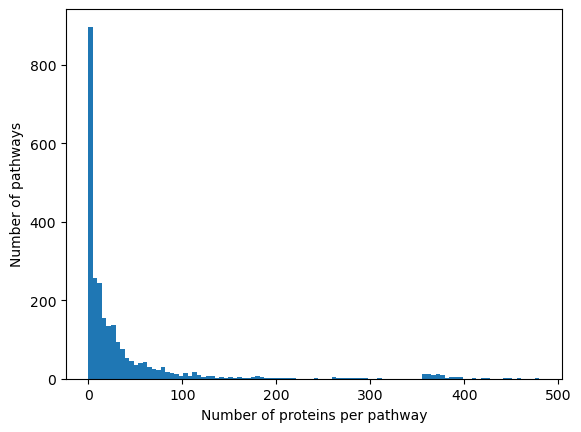

In [2]:
# Load data
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")

# Create graph from pathways
G = create_pathway_graph(pathways, translation, descendants=True)

print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Number of nodes with no edges: ", len([n for n in G.nodes if G.degree(n)==0]))
print("Mean number of edges per node: ", np.round(np.mean([G.degree(n) for n in G.nodes]),1))
print("Max number of edges per node: ", np.max([G.degree(n) for n in G.nodes]))
print("Min number of edges per node: ", np.min([G.degree(n) for n in G.nodes]))
print("Median number of edges per node: ", np.median([G.degree(n) for n in G.nodes]))
print("Number of nodes without proteins: ", len([n for n in G.nodes if len(G.nodes[n].get('proteins', '') )==0]))


num_proteins_per_pathway = [len(G.nodes[node].get('proteins', '')) for node in G.nodes()]
plt.hist(num_proteins_per_pathway, bins=100)
plt.xlabel("Number of proteins per pathway")
plt.ylabel("Number of pathways")
plt.show()


### 1.2 Artificial graph

## 2.0 Model pipelines

### 2.1 AKI dataset

In [3]:
# Load data
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# Preprocess input data
input_data_preprocessed = input_data_qm.fillna(0)
design_matrix = design_matrix.replace(1, 0)
design_matrix = design_matrix.replace(2, 1)

# split data into train and test
X_train = input_data_preprocessed.loc[:, input_data_preprocessed.columns.str.contains("M2012") | input_data_preprocessed.columns.str.contains("Protein")]
X_test = input_data_preprocessed.loc[:, ~input_data_preprocessed.columns.str.contains("M2012") | input_data_preprocessed.columns.str.contains("Protein")]

y_train = design_matrix[design_matrix['sample'].str.contains("M2012")]
y_test = design_matrix[~design_matrix['sample'].str.contains("M2012")]

In [4]:
# Create PyTorch Geometric Data objects for train and test data
train_graph_data = pytorch_graphdata(y_train, X_train, G, gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/AKI_train_graph_data.pkl')
test_graph_data = pytorch_graphdata(y_test, X_test, G, gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/AKI_test_graph_data.pkl')

print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 554
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 554], edge_index=[2, 2603], y=[1])


#### 2.1.1 GCN

Cross validaton

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0001
weight_decay = 0.05
batch_size = 32
layer_configs = [{"in_channels": 32, "out_channels": 32, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1}]

# Initialize model
num_features = train_graph_data[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = False
save_path = "trained_models/ResGCN_AKI"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path,
                  save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Average validation accuracy: 0.965 +/- 0.04
Average validation roc_auc: 0.975 +/- 0.03
Average validation f1_macro: 0.964 +/- 0.04
Average validation f1_phen1: 0.969 +/- 0.03
Average validation f1_phen2: 0.96 +/- 0.04
Average validation recall_phen1: 0.951 +/- 0.04
Average validation recall_phen2: 0.983 +/- 0.03
Average validation precision_phen1: 0.987 +/- 0.02
Average validation precision_phen2: 0.938 +/- 0.06


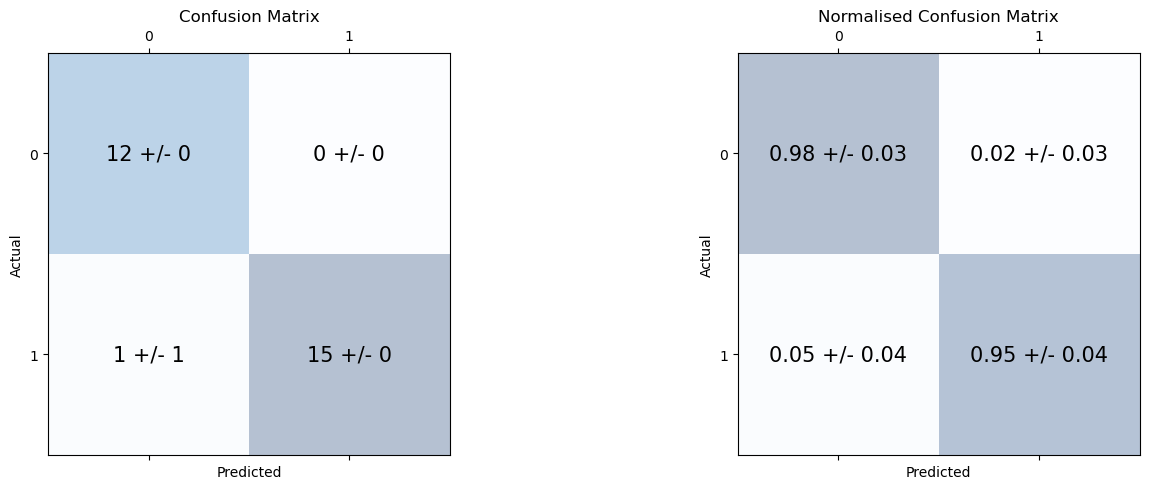

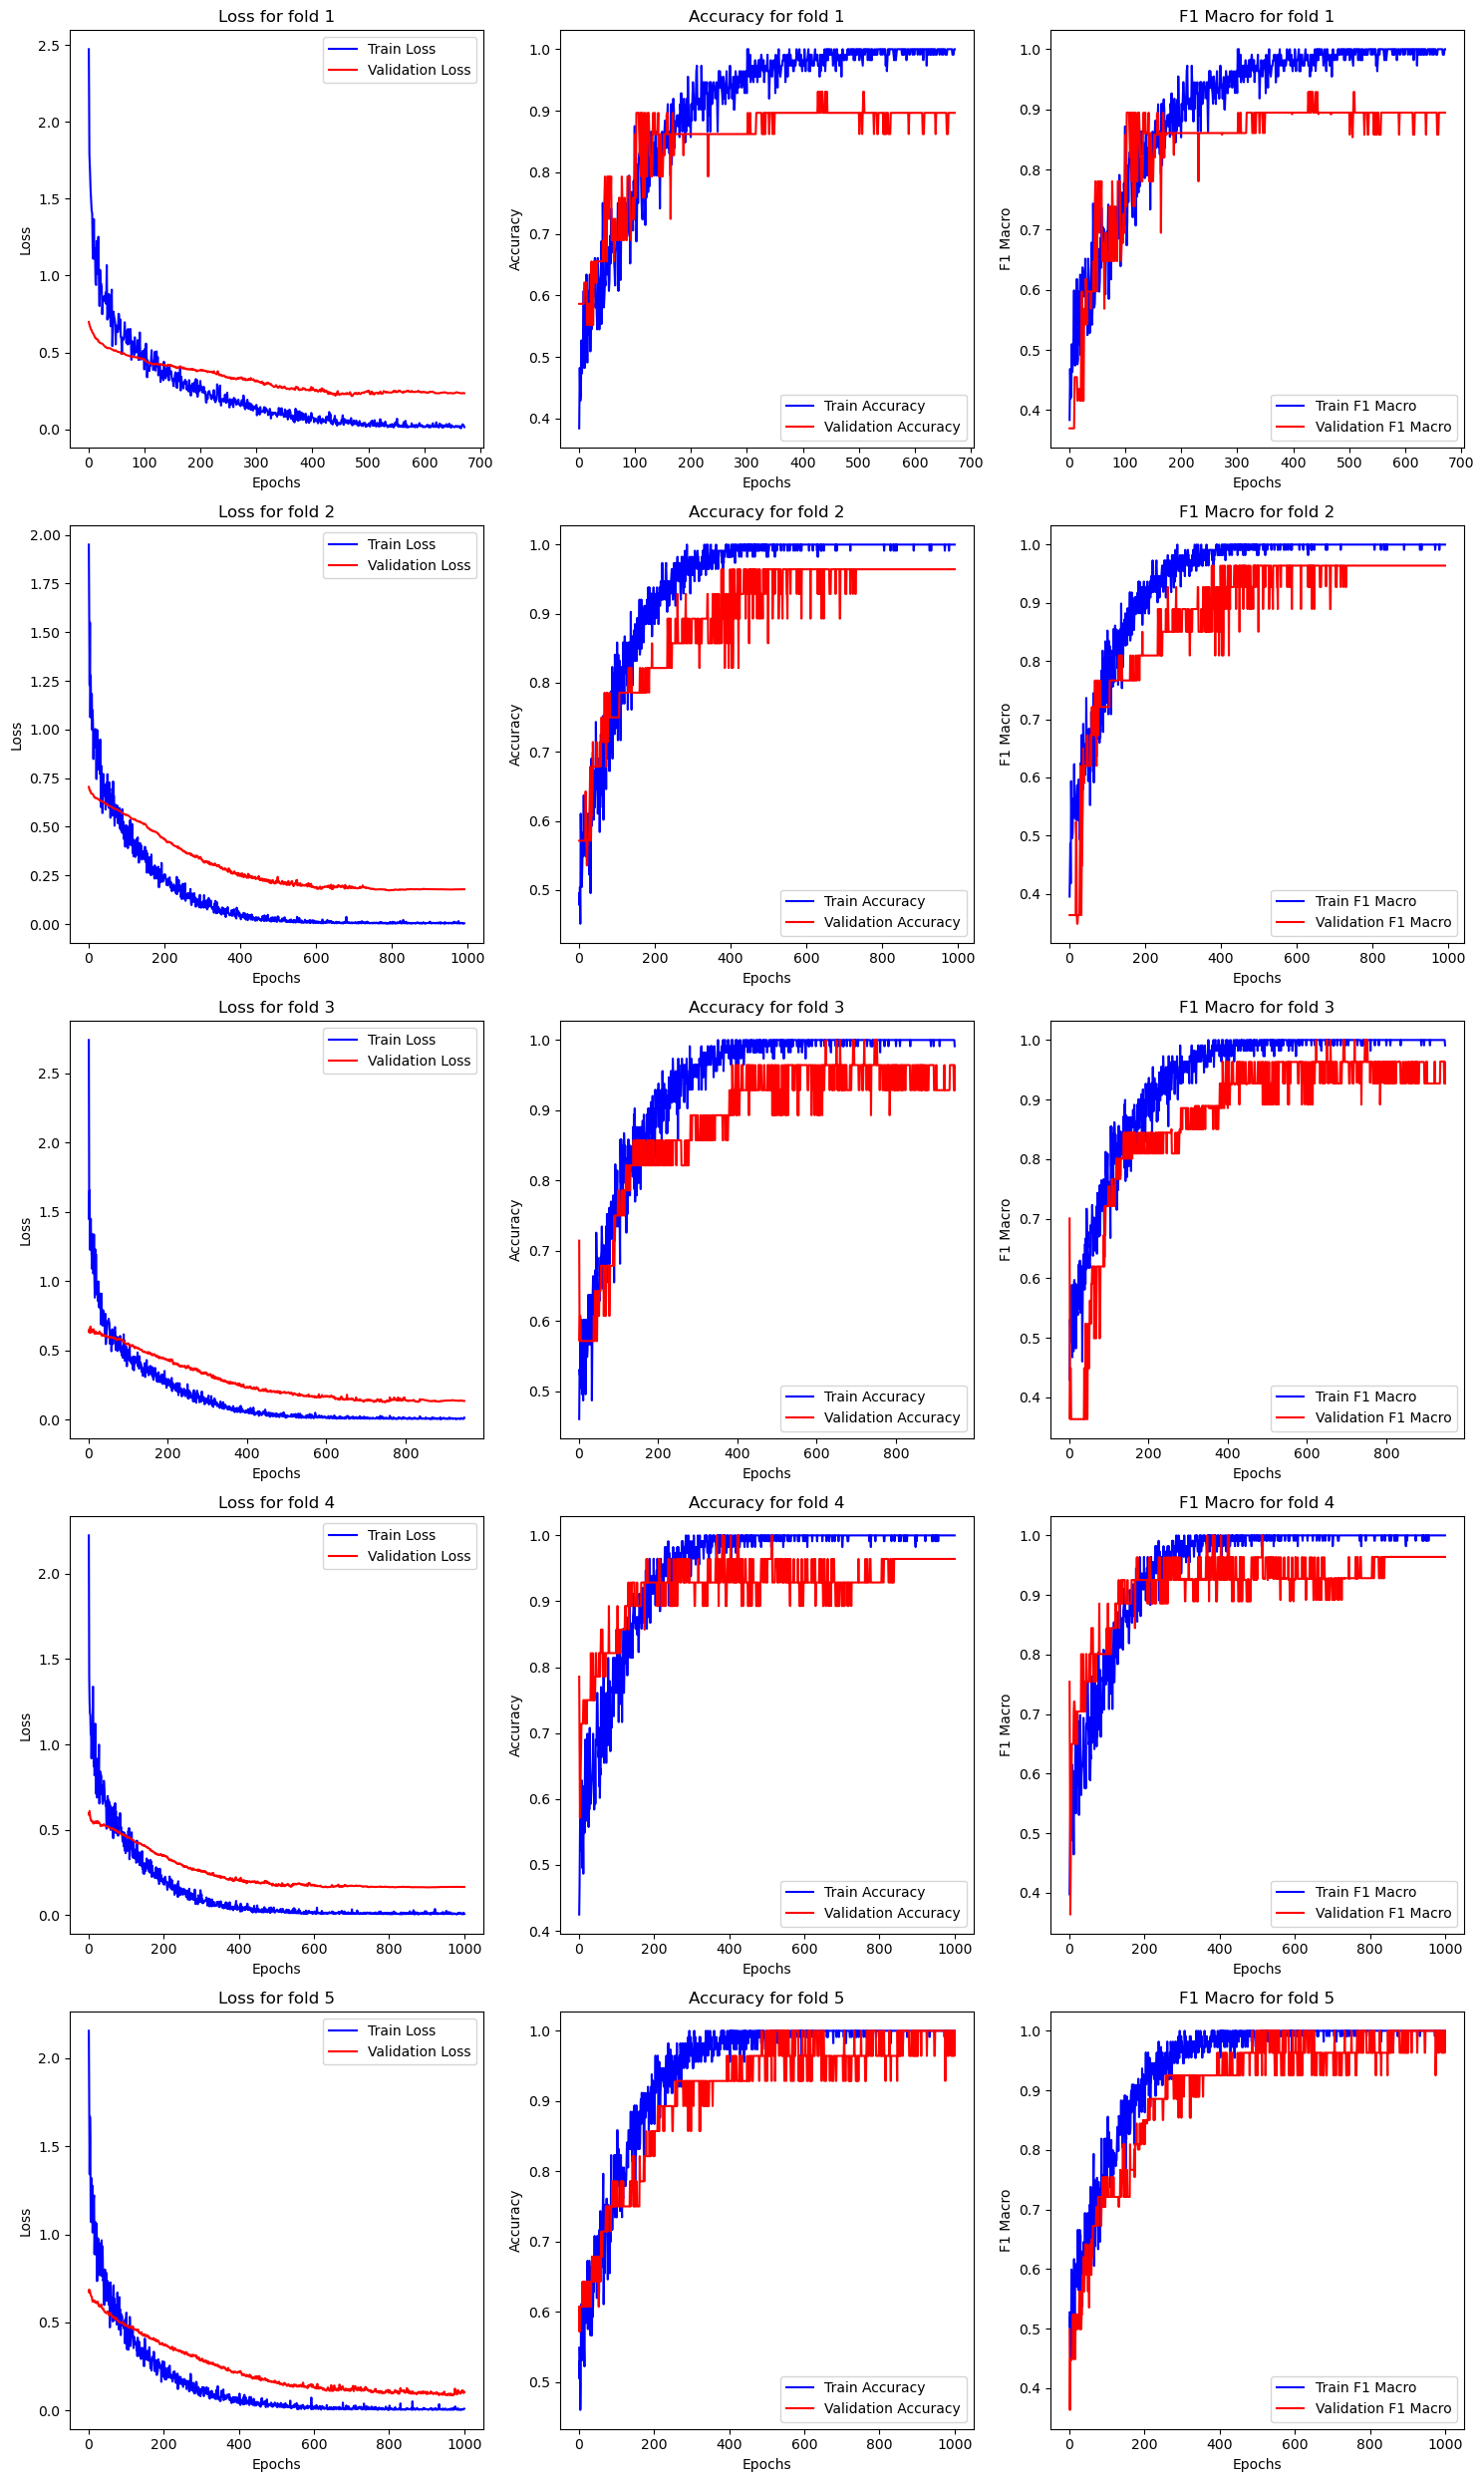

In [7]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.8929
Test ROC_AUC: 0.9371
Test F1 Macro: 0.8497
Test F1 Phen1: 0.9302
Test F1 Phen2: 0.7692
Test Recall Phen1: 0.9524
Test Recall Phen2: 0.7143


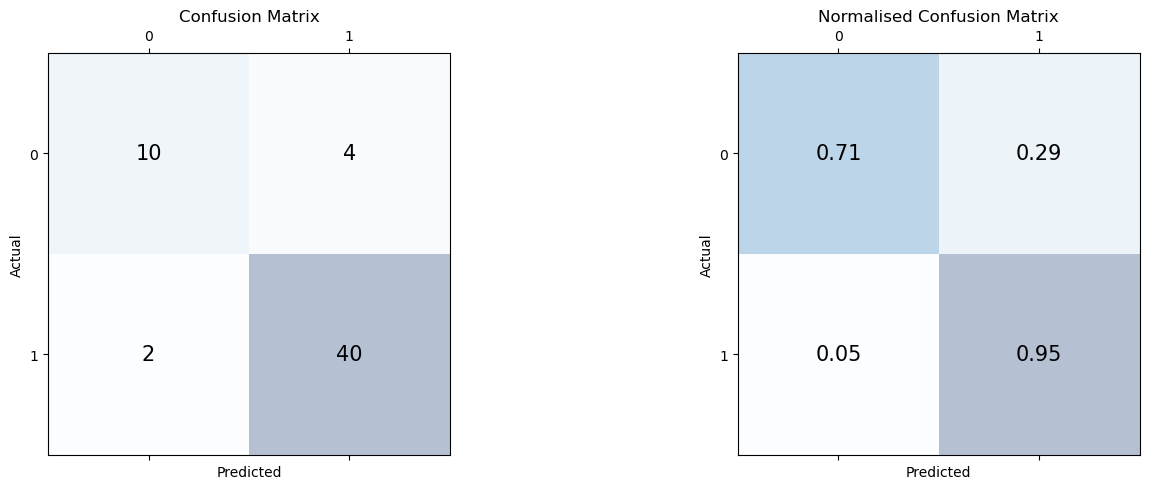

In [73]:
# load trained models
models = []
for i in range(5): 
    model = ResGCN(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/AKI_ResGCN_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')

#### 2.1.2 GAT

Cross validation

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0005
weight_decay = 0.2
batch_size = 32
layer_configs = [{"in_channels": 64, "out_channels": 64, "heads": 1, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1},
              {"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1}]

# Initialize model
num_features = train_graph_data[0].num_features
num_classes = 2
create_model_fn = lambda: ResGAT(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=50, verbose=True)
use_scheduler = True

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5

# Saving configurations
save_models = False
save_path = "trained_models/AKI_ResGAT"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path,
                  save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Average validation accuracy: 0.943 +/- 0.02
Average validation roc_auc: 0.977 +/- 0.03
Average validation f1_macro: 0.942 +/- 0.02
Average validation f1_phen1: 0.95 +/- 0.01
Average validation f1_phen2: 0.934 +/- 0.02
Average validation recall_phen1: 0.938 +/- 0.0
Average validation recall_phen2: 0.95 +/- 0.04
Average validation precision_phen1: 0.963 +/- 0.03
Average validation precision_phen2: 0.919 +/- 0.0


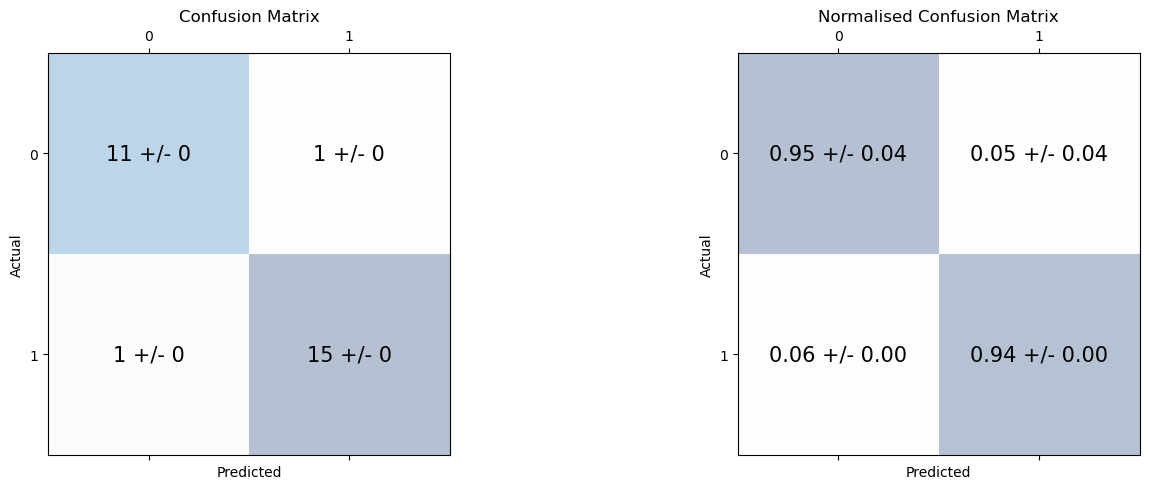

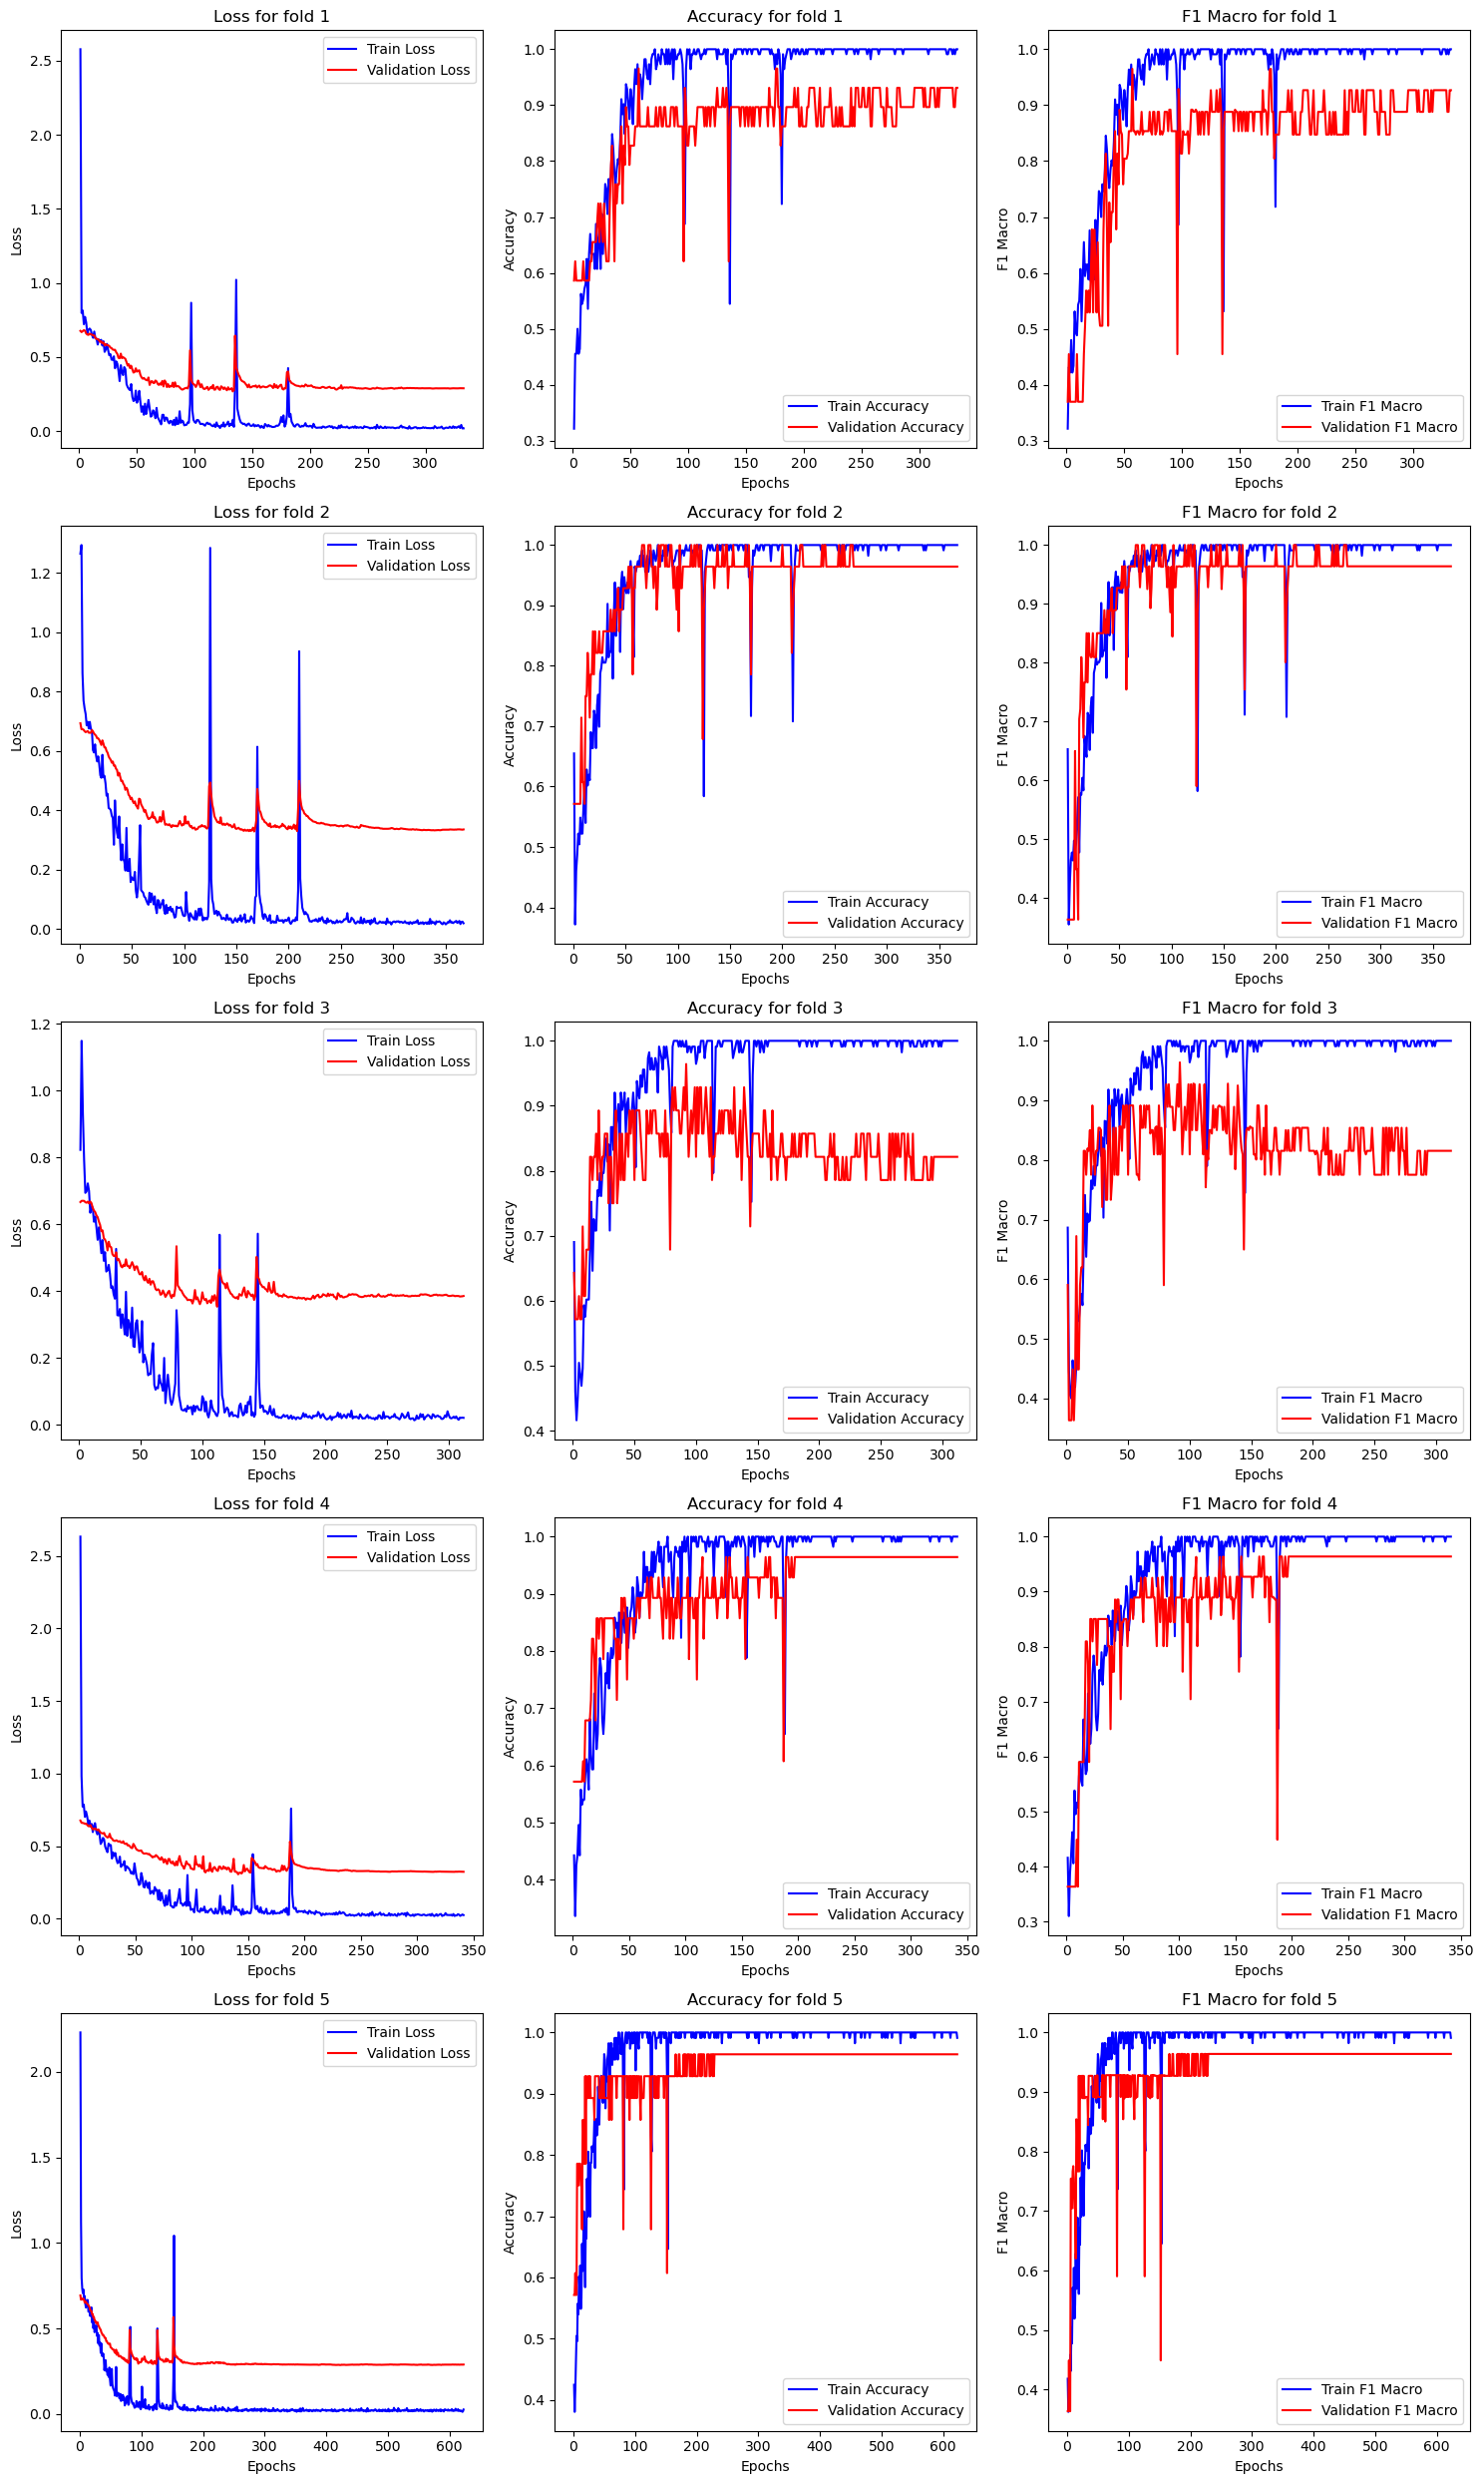

In [67]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.9107
Test ROC_AUC: 0.9677
Test F1 Macro: 0.8632
Test F1 Phen1: 0.9438
Test F1 Phen2: 0.7826
Test Recall Phen1: 1.0000
Test Recall Phen2: 0.6429


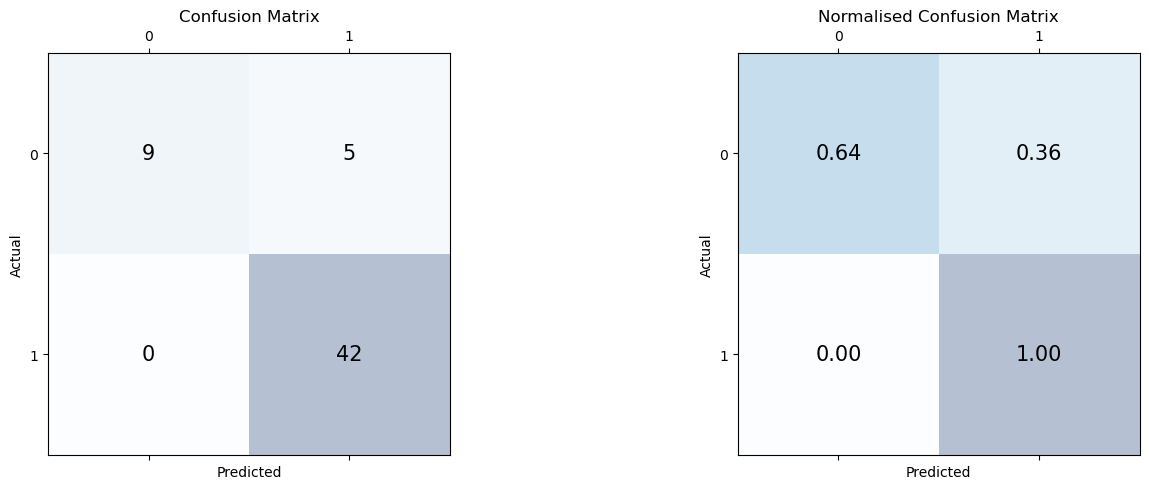

In [68]:
# load trained models
models = []
for i in range(5): 
    model = ResGAT(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/AKI_ResGAT_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')

### 2.2 AKI dataset with perturbed Graph

In [39]:
# randomize protein assignment and pertubed graph edges
translation_pert = translation.copy()
trans = translation_pert['translation'].tolist()
random.shuffle(trans)
translation_pert['translation'] = trans

G_pert = create_pathway_graph(pathways, translation_pert, descendants=True, perturb = True, edge_removal_prob=0.9, edge_addition_prob=0.0005)

# check overlap between original and perturbed graph edges connections to nodes
overlap = []
for node in G.nodes():
    overlap.append(len(set(G[node]).intersection(G_pert[node])))
print(f"Mean overlap: {np.mean(overlap)}")

Mean overlap: 0.10174081237911026


In [53]:
# Create PyTorch Geometric Data objects for train and test data
train_graph_data_pert = pytorch_graphdata(y_train, X_train, G_pert , gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/AKI_train_graph_data_pert.pkl')
test_graph_data_pert = pytorch_graphdata(y_test, X_test, G_pert , gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/AKI_test_graph_data_pert.pkl')

print(f"Number of training graphs: {len(train_graph_data_pert)}")
print(f"Number of test graphs: {len(test_graph_data_pert)}")
print(f"Number of features: {train_graph_data_pert[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data_pert])}")
print(f"Is directed: {train_graph_data_pert[0].is_directed()}")
print(train_graph_data_pert[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 554
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 554], edge_index=[2, 3600], y=[1])


#### 2.2.1 GCN

Cross validaton

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0005
weight_decay = 0.05
batch_size = 32
layer_configs = [{"in_channels": 32, "out_channels": 32, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 128, "relu": True, "batch_norm": False, "dropout_rate": 0.1},
              {"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1}]

# Initialize model
num_features = train_graph_data_pert[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=50, verbose=True)

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = False
save_path = "trained_models/AKI_PERT_ResGCN"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data_pert, train_labels, batch_size, num_epochs, device, save_path,
                   save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Average validation accuracy: 0.965 +/- 0.03
Average validation roc_auc: 0.976 +/- 0.03
Average validation f1_macro: 0.964 +/- 0.03
Average validation f1_phen1: 0.968 +/- 0.03
Average validation f1_phen2: 0.96 +/- 0.04
Average validation recall_phen1: 0.951 +/- 0.05
Average validation recall_phen2: 0.983 +/- 0.03
Average validation precision_phen1: 0.988 +/- 0.02
Average validation precision_phen2: 0.939 +/- 0.05


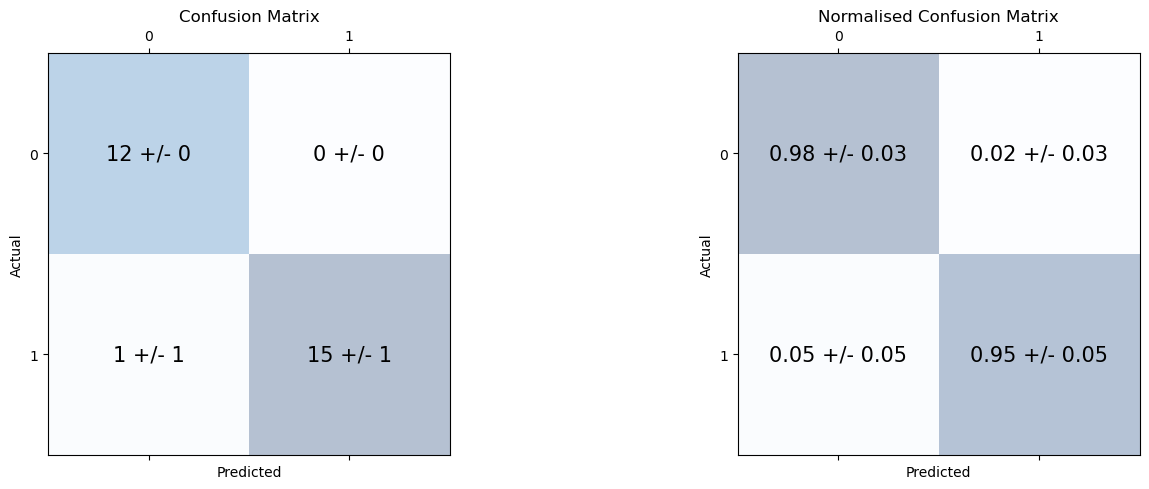

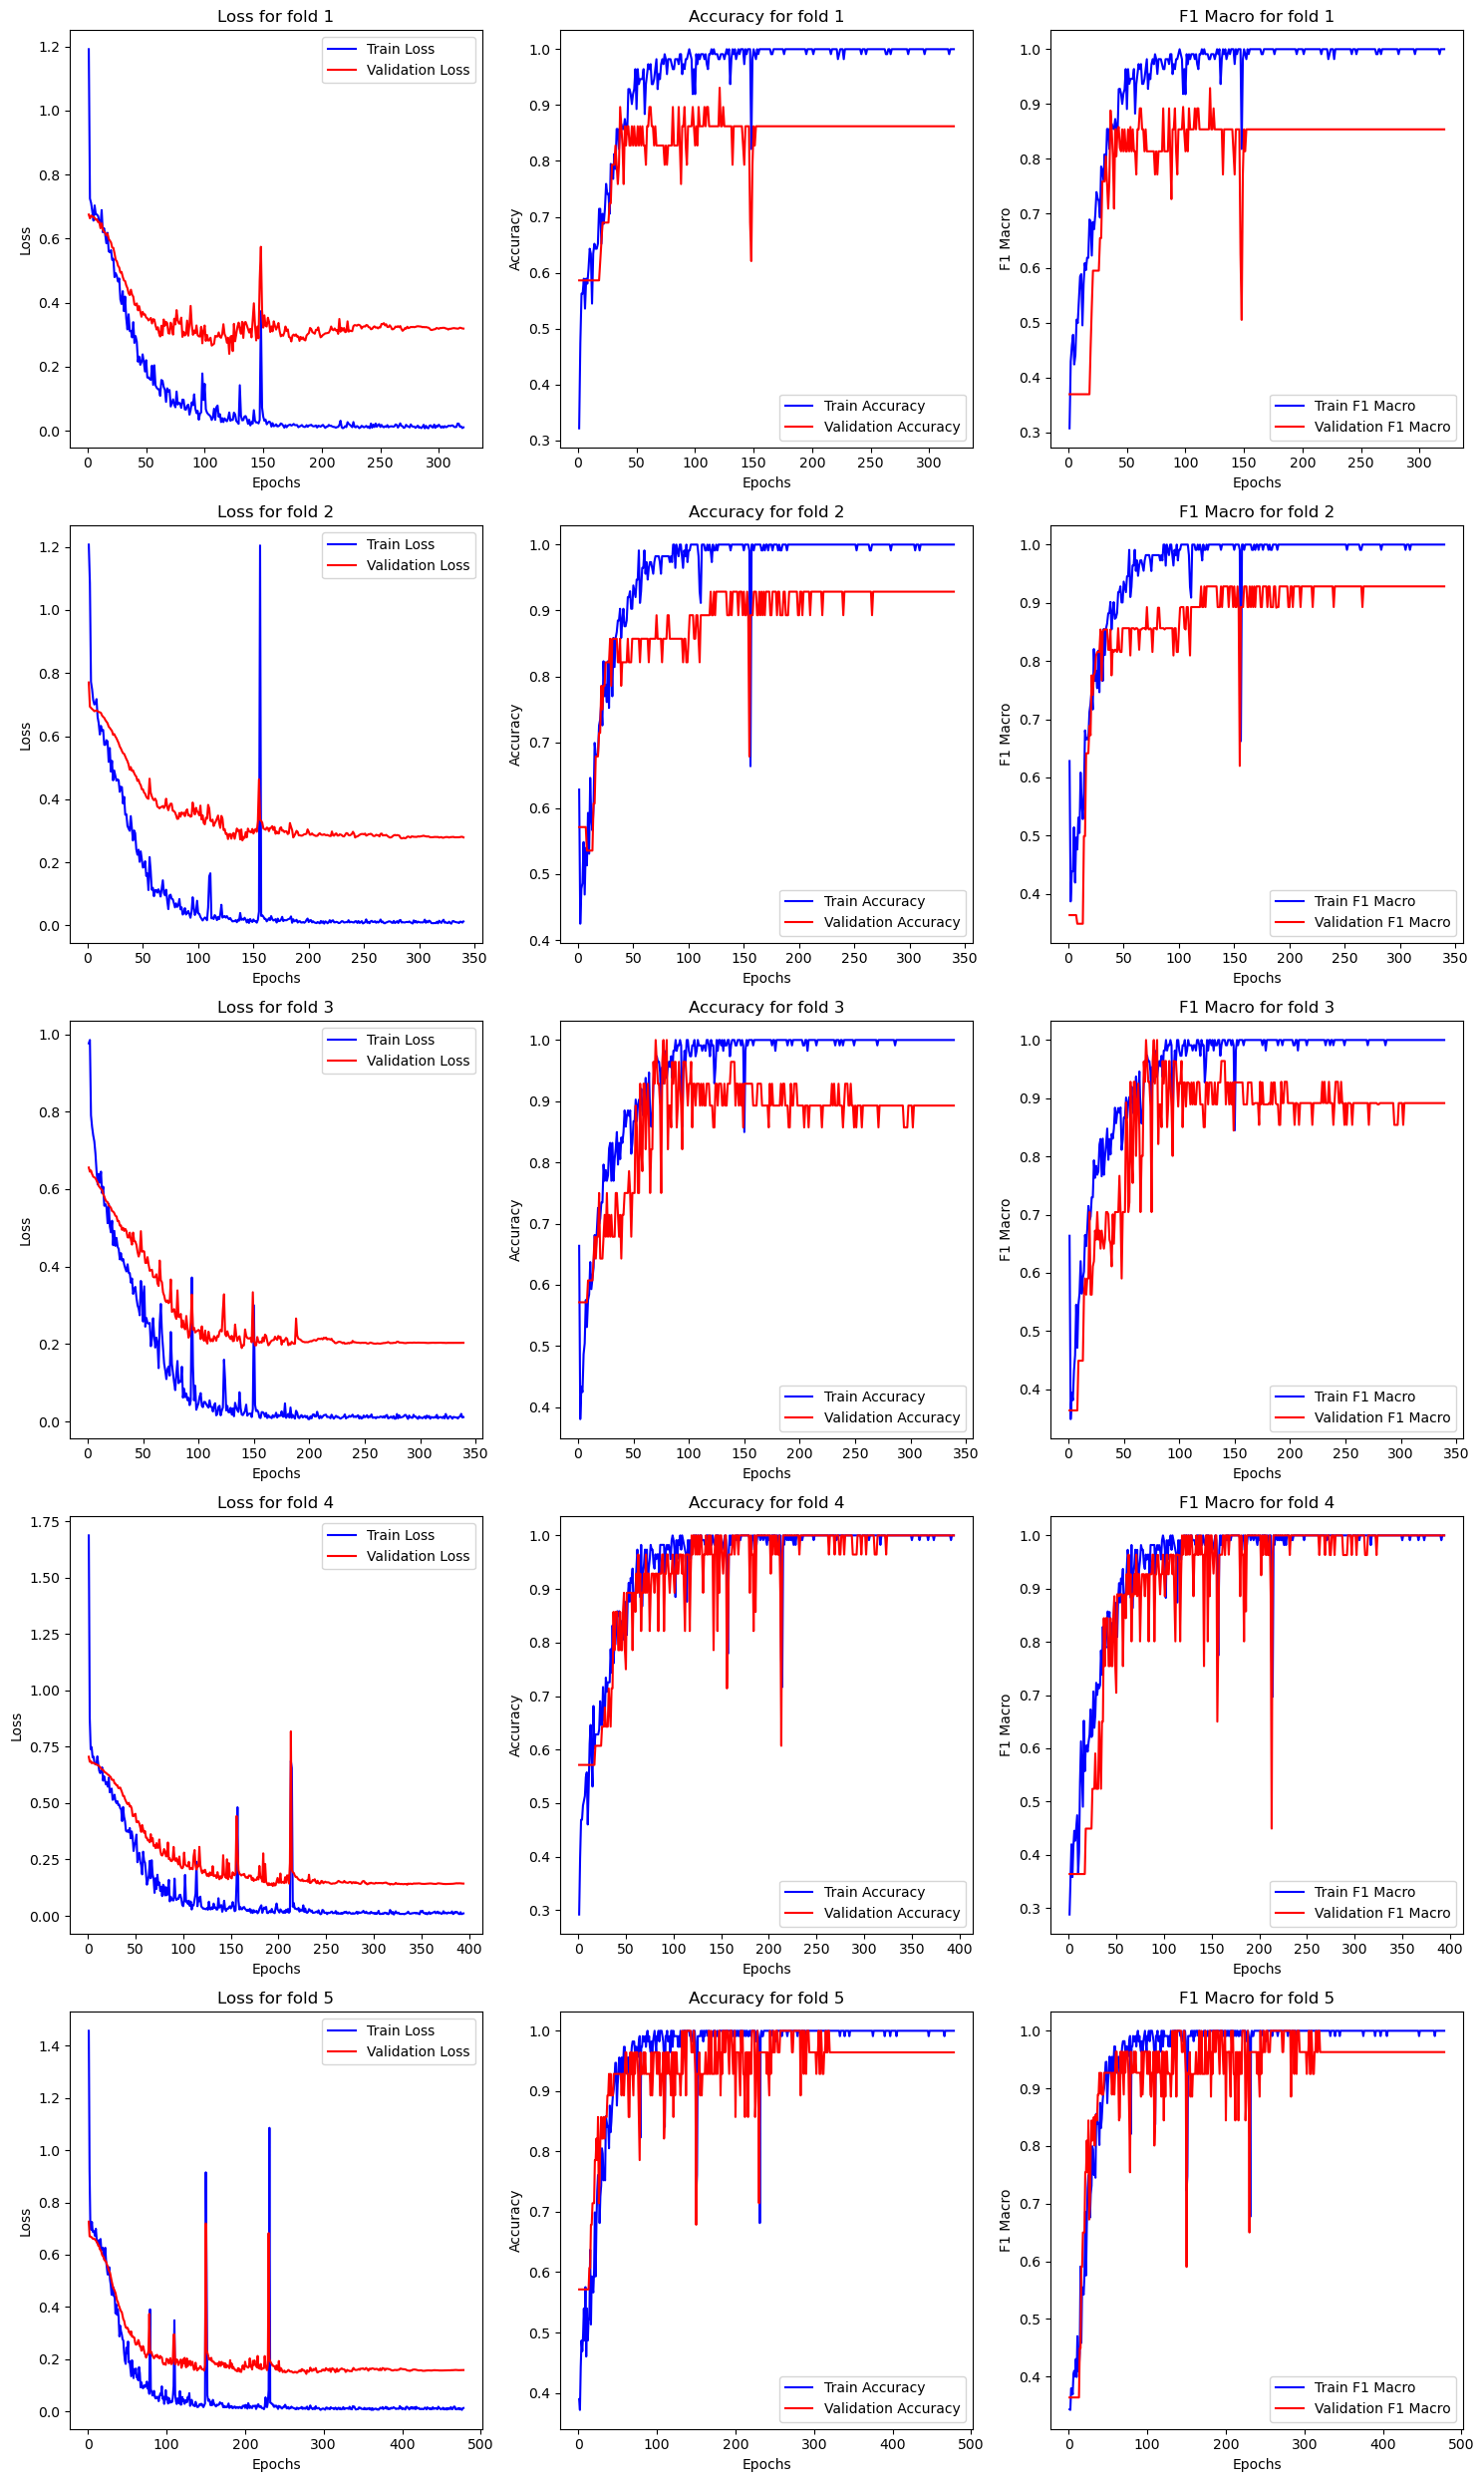

In [59]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.9643
Test ROC_AUC: 0.9643
Test F1 Macro: 0.9524
Test F1 Phen1: 0.9762
Test F1 Phen2: 0.9286
Test Recall Phen1: 0.9762
Test Recall Phen2: 0.9286


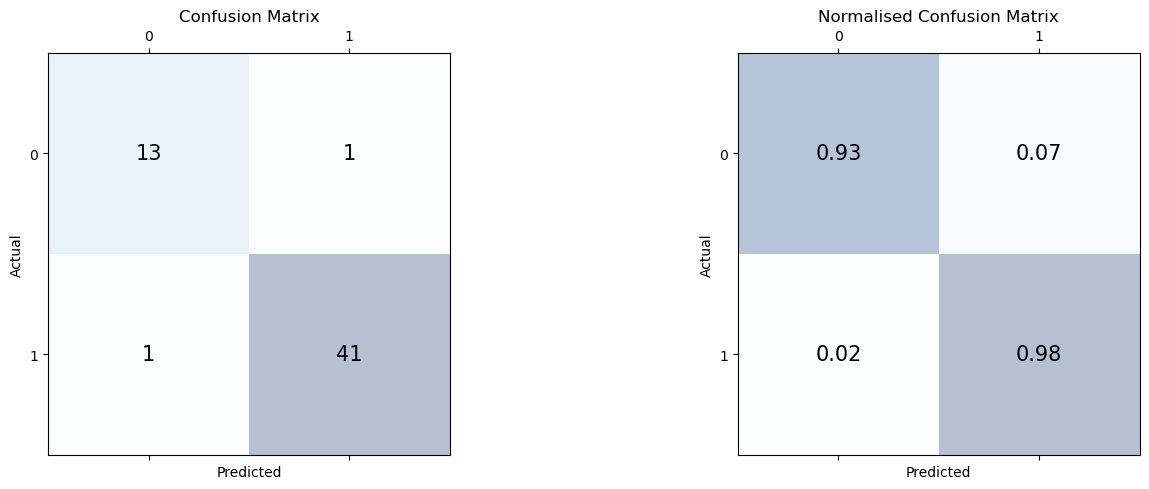

In [56]:
# load trained models
models = []
for i in range(5): 
    model = ResGCN(train_graph_data_pert[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/AKI_PERT_ResGCN_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data_pert, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')

### 2.3 COVID-19 dataset

In [34]:
# Load COVID data
charite_data_X = pd.read_csv('covid_data/covid_train.tsv', sep='\t')
ins_data_X = pd.read_csv('covid_data/covid_test.txt', sep='\t', index_col=0)
charite_data_y = pd.read_csv('covid_data/covid_train_design.tsv', sep='\t')
ins_data_y = pd.read_csv('covid_data/covid_test_design.txt', sep='\t', index_col=0)

# Merge data
X = pd.merge(charite_data_X, ins_data_X, on='Protein', how='inner')
y = pd.concat([charite_data_y, ins_data_y])

# Preprocess data
X = X.fillna(0)
y = y.replace(1, 0)
y = y.replace(2, 1)

# perform train test split on data by splitting sample column of y
train_size = 0.9
patients = y['sample']
train_patients = random.sample(list(patients), int(train_size*len(patients)))
test_patients = [p for p in patients if p not in train_patients]

# select 'Protein' column and columns corresponding to train and test patients
X_train = X.loc[:, X.columns.str.contains("Protein") | X.columns.isin(train_patients)]
X_test = X.loc[:, X.columns.str.contains("Protein") | X.columns.isin(test_patients)]
y_train = y[y['sample'].isin(train_patients)]
y_test = y[y['sample'].isin(test_patients)]

# save train and test data
X_train.to_csv('covid_data/covid_train_qm.csv')
X_test.to_csv('covid_data/covid_test_qm.csv')
y_train.to_csv('covid_data/covid_train_design_qm.csv')
y_test.to_csv('covid_data/covid_test_design_qm.csv')

In [14]:
# Create PyTorch Geometric Data objects for train and test data
train_graph_data_covid = pytorch_graphdata(y_train, X_train, G, gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/COVID_train_graph_data.pkl')
test_graph_data_covid = pytorch_graphdata(y_test, X_test, G, gen_column = 'Protein', load_data = True, save_data = False, path = '/scratch/yves/DL_files/COVID_test_graph_data.pkl')

print(f"Number of training graphs: {len(train_graph_data_covid)}")
print(f"Number of test graphs: {len(test_graph_data_covid)}")
print(f"Number of features: {train_graph_data_covid[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data_covid])}")
print(f"Is directed: {train_graph_data_covid[0].is_directed()}")
print(train_graph_data_covid[0])

Number of training graphs: 707
Number of test graphs: 79
Number of features: 169
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 169], edge_index=[2, 2603], y=[1])


#### 2.3.1 GCN

Cross validaton

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0005
weight_decay = 0.005
batch_size = 32
layer_configs = [{"in_channels": 16, "out_channels": 16, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 128, "relu": True, "batch_norm": False, "dropout_rate": 0.5},
              {"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.5},
              {"out_channels": 32, "relu": True, "batch_norm": False, "dropout_rate": 0.5}]

# Initialize model
num_features = train_graph_data_covid[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=50, verbose=True)

# Training configurations
train_labels = y_train['group']
num_epochs = 1000
early_stopping_patience = 100
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = True
save_path = "trained_models/COVID_ResGCN"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data_covid, train_labels, batch_size, num_epochs, device, save_path,
                   save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Average validation accuracy: 0.82 +/- 0.03
Average validation roc_auc: 0.892 +/- 0.04
Average validation f1_macro: 0.819 +/- 0.03
Average validation f1_phen1: 0.833 +/- 0.03
Average validation f1_phen2: 0.806 +/- 0.03
Average validation recall_phen1: 0.823 +/- 0.05
Average validation recall_phen2: 0.817 +/- 0.04
Average validation precision_phen1: 0.844 +/- 0.03
Average validation precision_phen2: 0.797 +/- 0.04


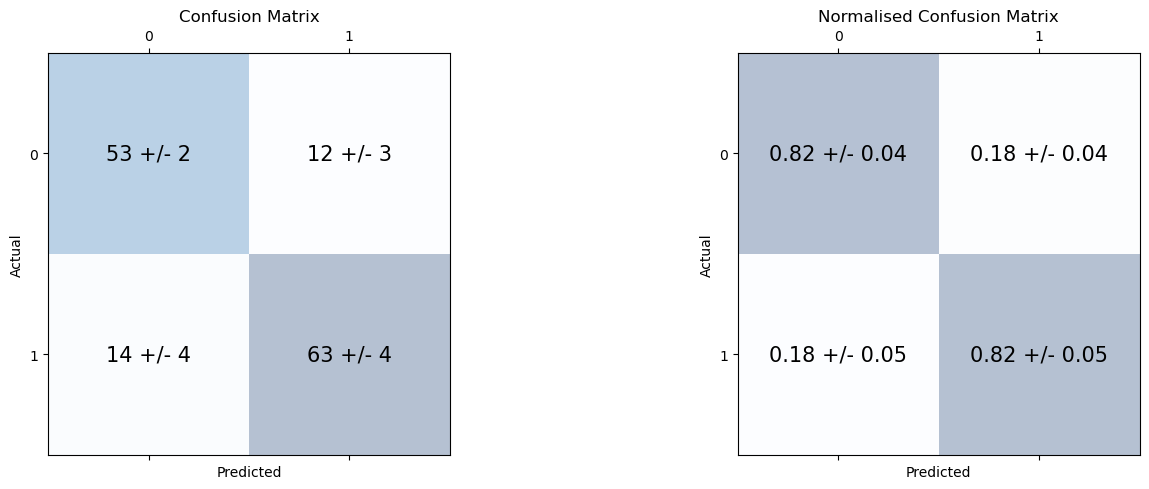

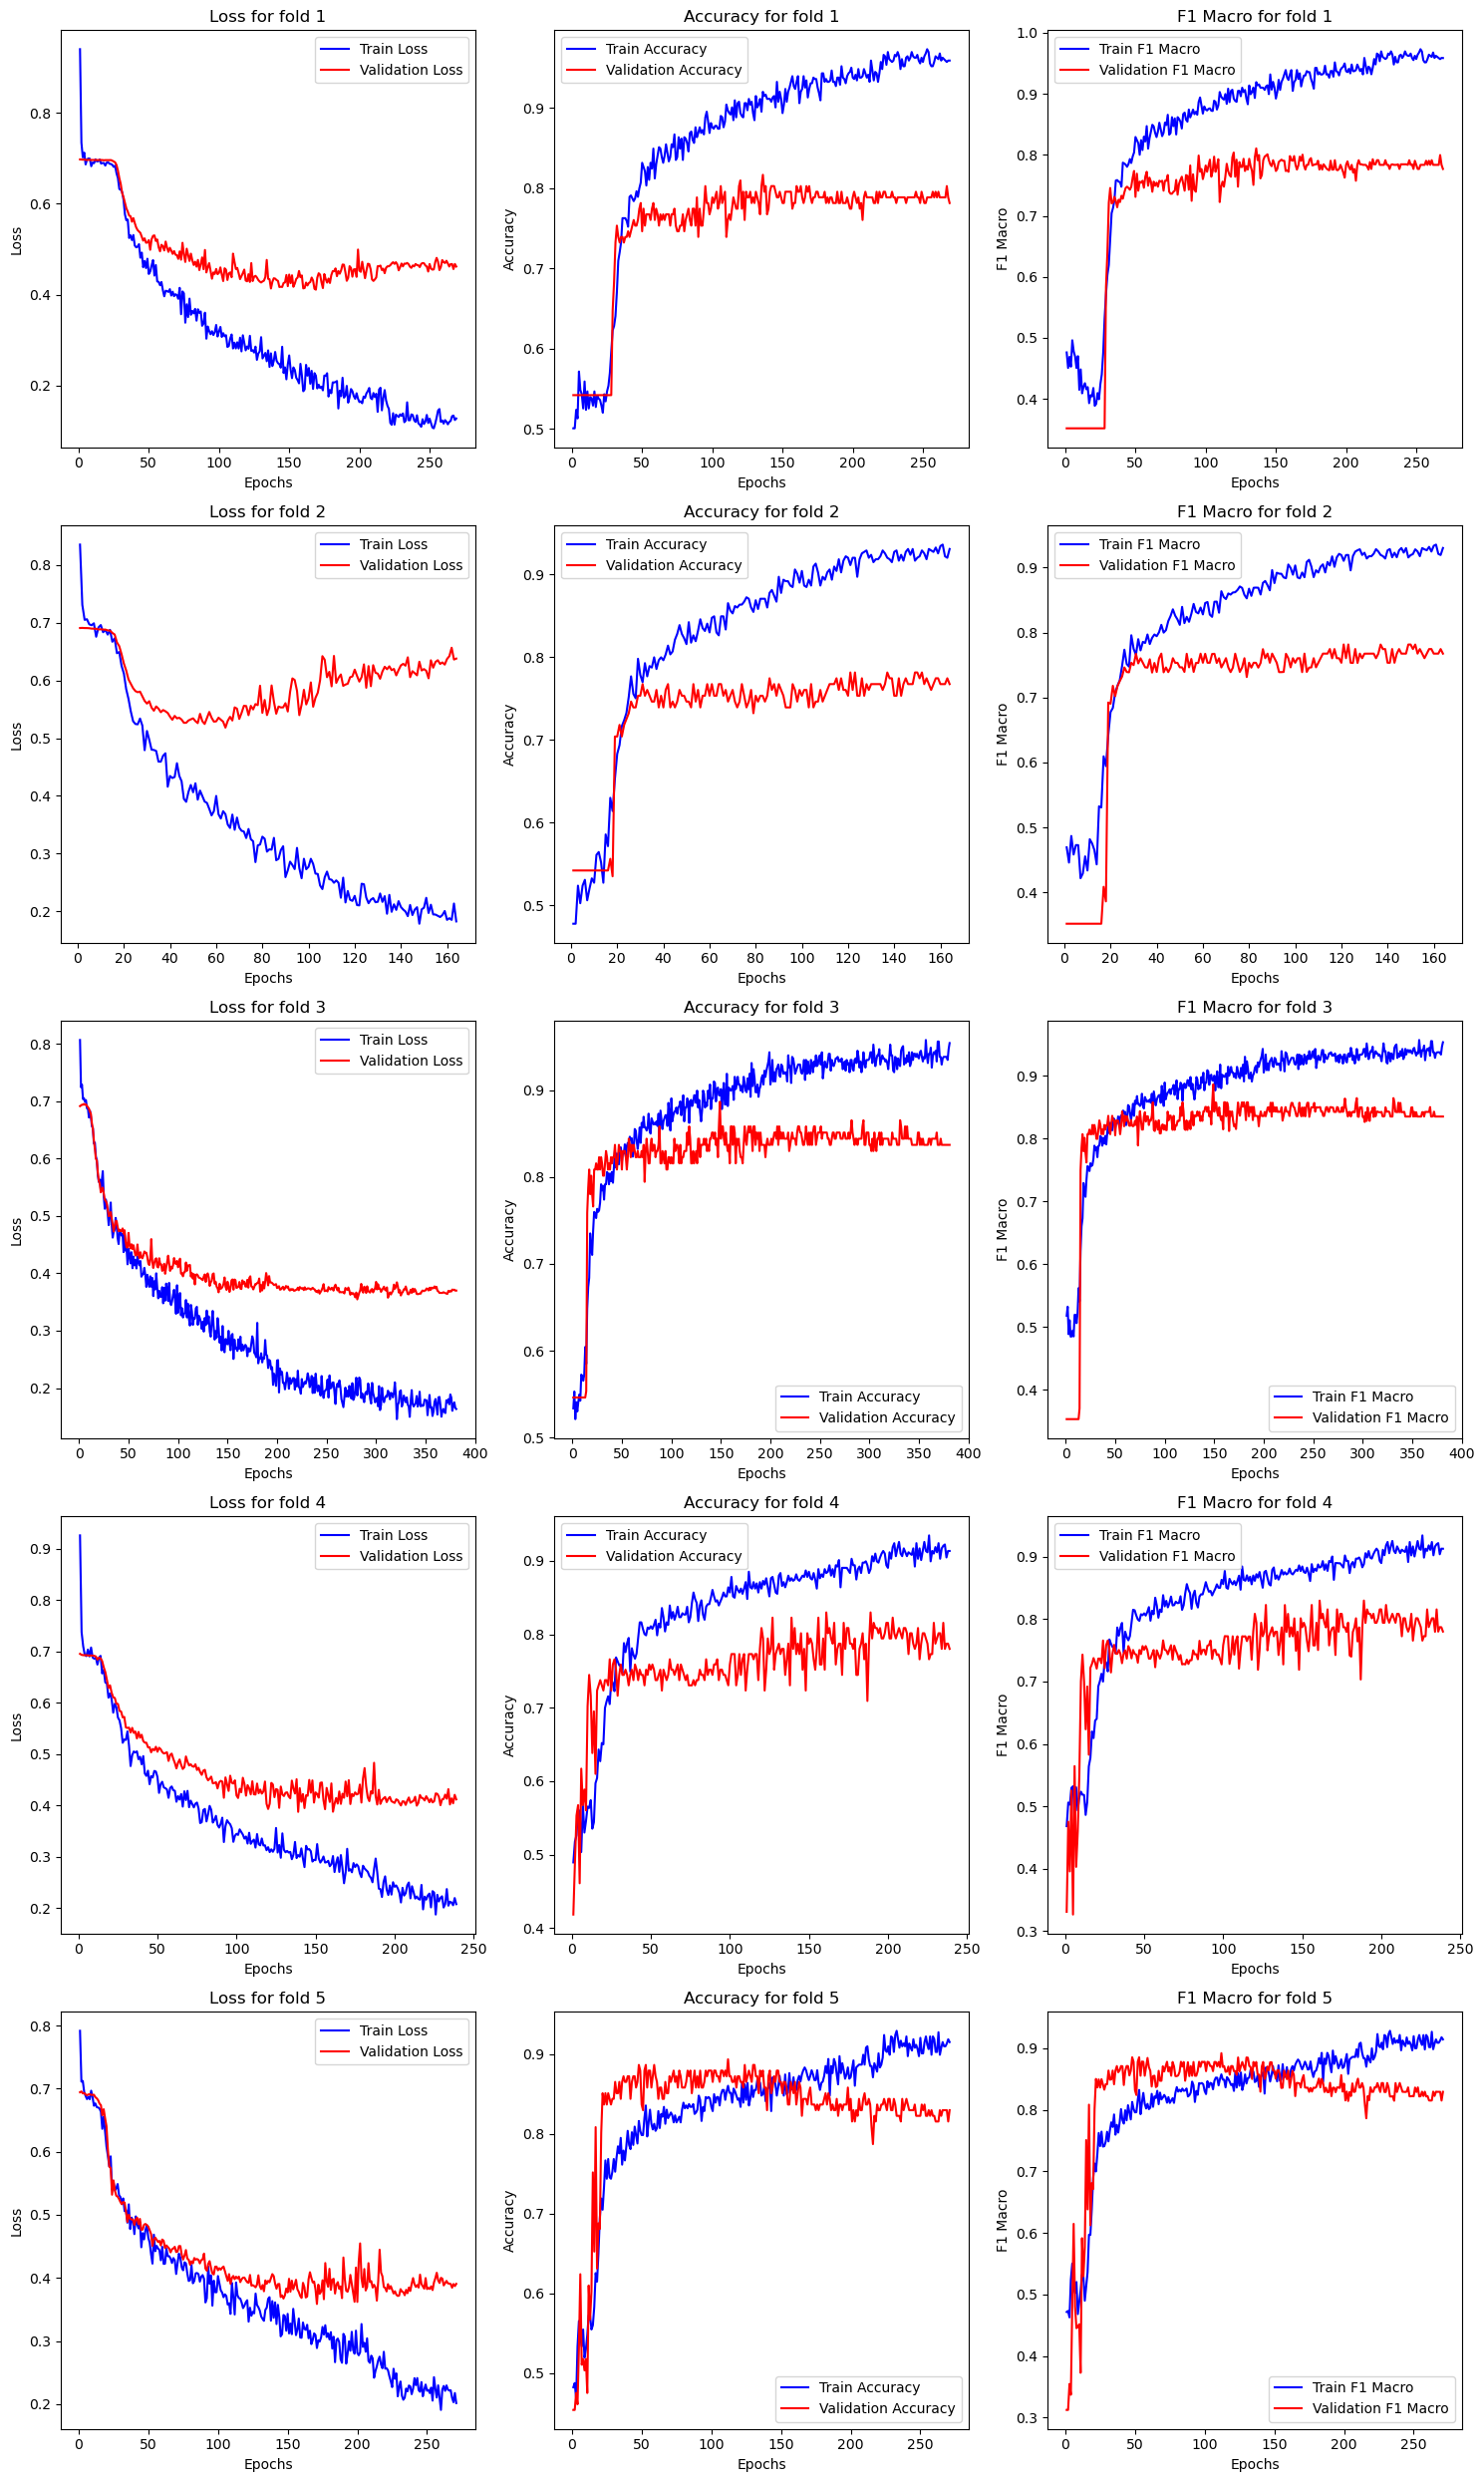

In [32]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.8608
Test ROC_AUC: 0.9588
Test F1 Macro: 0.8607
Test F1 Phen1: 0.8642
Test F1 Phen2: 0.8571
Test Recall Phen1: 0.7778
Test Recall Phen2: 0.9706


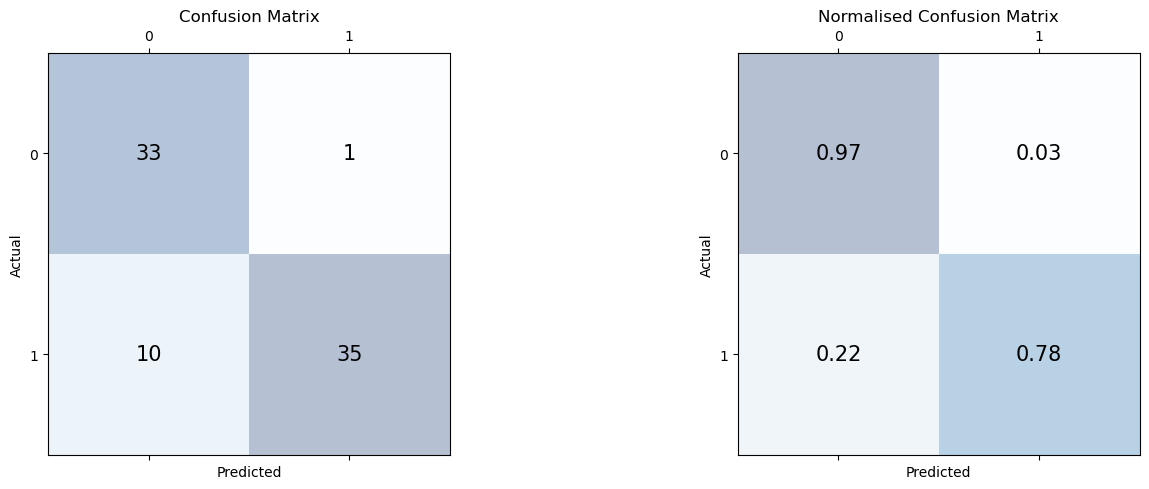

In [33]:
# load trained models
models = []
for i in range(5): 
    model = ResGCN(train_graph_data_covid[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/COVID_ResGCN_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data_covid, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')

#### 2.3.2 GAT

Cross validation

In [57]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.001
weight_decay = 0.01
batch_size = 32
layer_configs = [{"in_channels": 16, "out_channels": 16, "heads": 1, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 128, "relu": True, "batch_norm": False, "dropout_rate": 0.5},
              {"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.5}]

# Initialize model
num_features = train_graph_data_covid[0].num_features
num_classes = 2
create_model_fn = lambda: ResGAT(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=50, verbose=True)
use_scheduler = True

# Training configurations
train_labels = y_train['group']
num_epochs = 1000
early_stopping_patience = 100
FOLDS = 5

# Saving configurations
save_models = True
save_path = "trained_models/COVID_ResGAT"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data_covid, train_labels, batch_size, num_epochs, device, save_path,
                  save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Using device: cuda


Average validation accuracy: 0.789 +/- 0.03
Average validation roc_auc: 0.866 +/- 0.04
Average validation f1_macro: 0.785 +/- 0.04
Average validation f1_phen1: 0.806 +/- 0.03
Average validation f1_phen2: 0.764 +/- 0.05
Average validation recall_phen1: 0.807 +/- 0.03
Average validation recall_phen2: 0.763 +/- 0.06
Average validation precision_phen1: 0.806 +/- 0.03
Average validation precision_phen2: 0.766 +/- 0.05


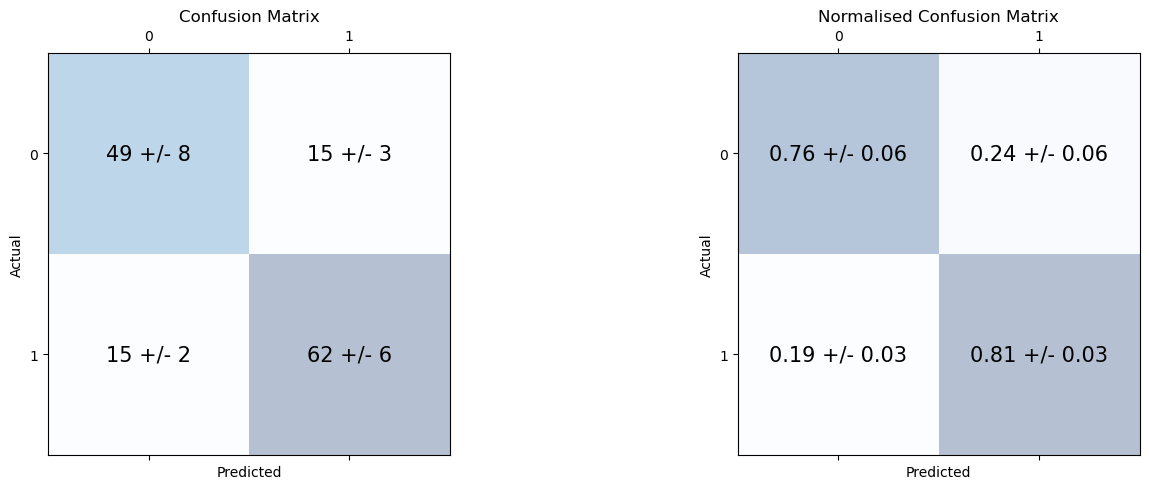

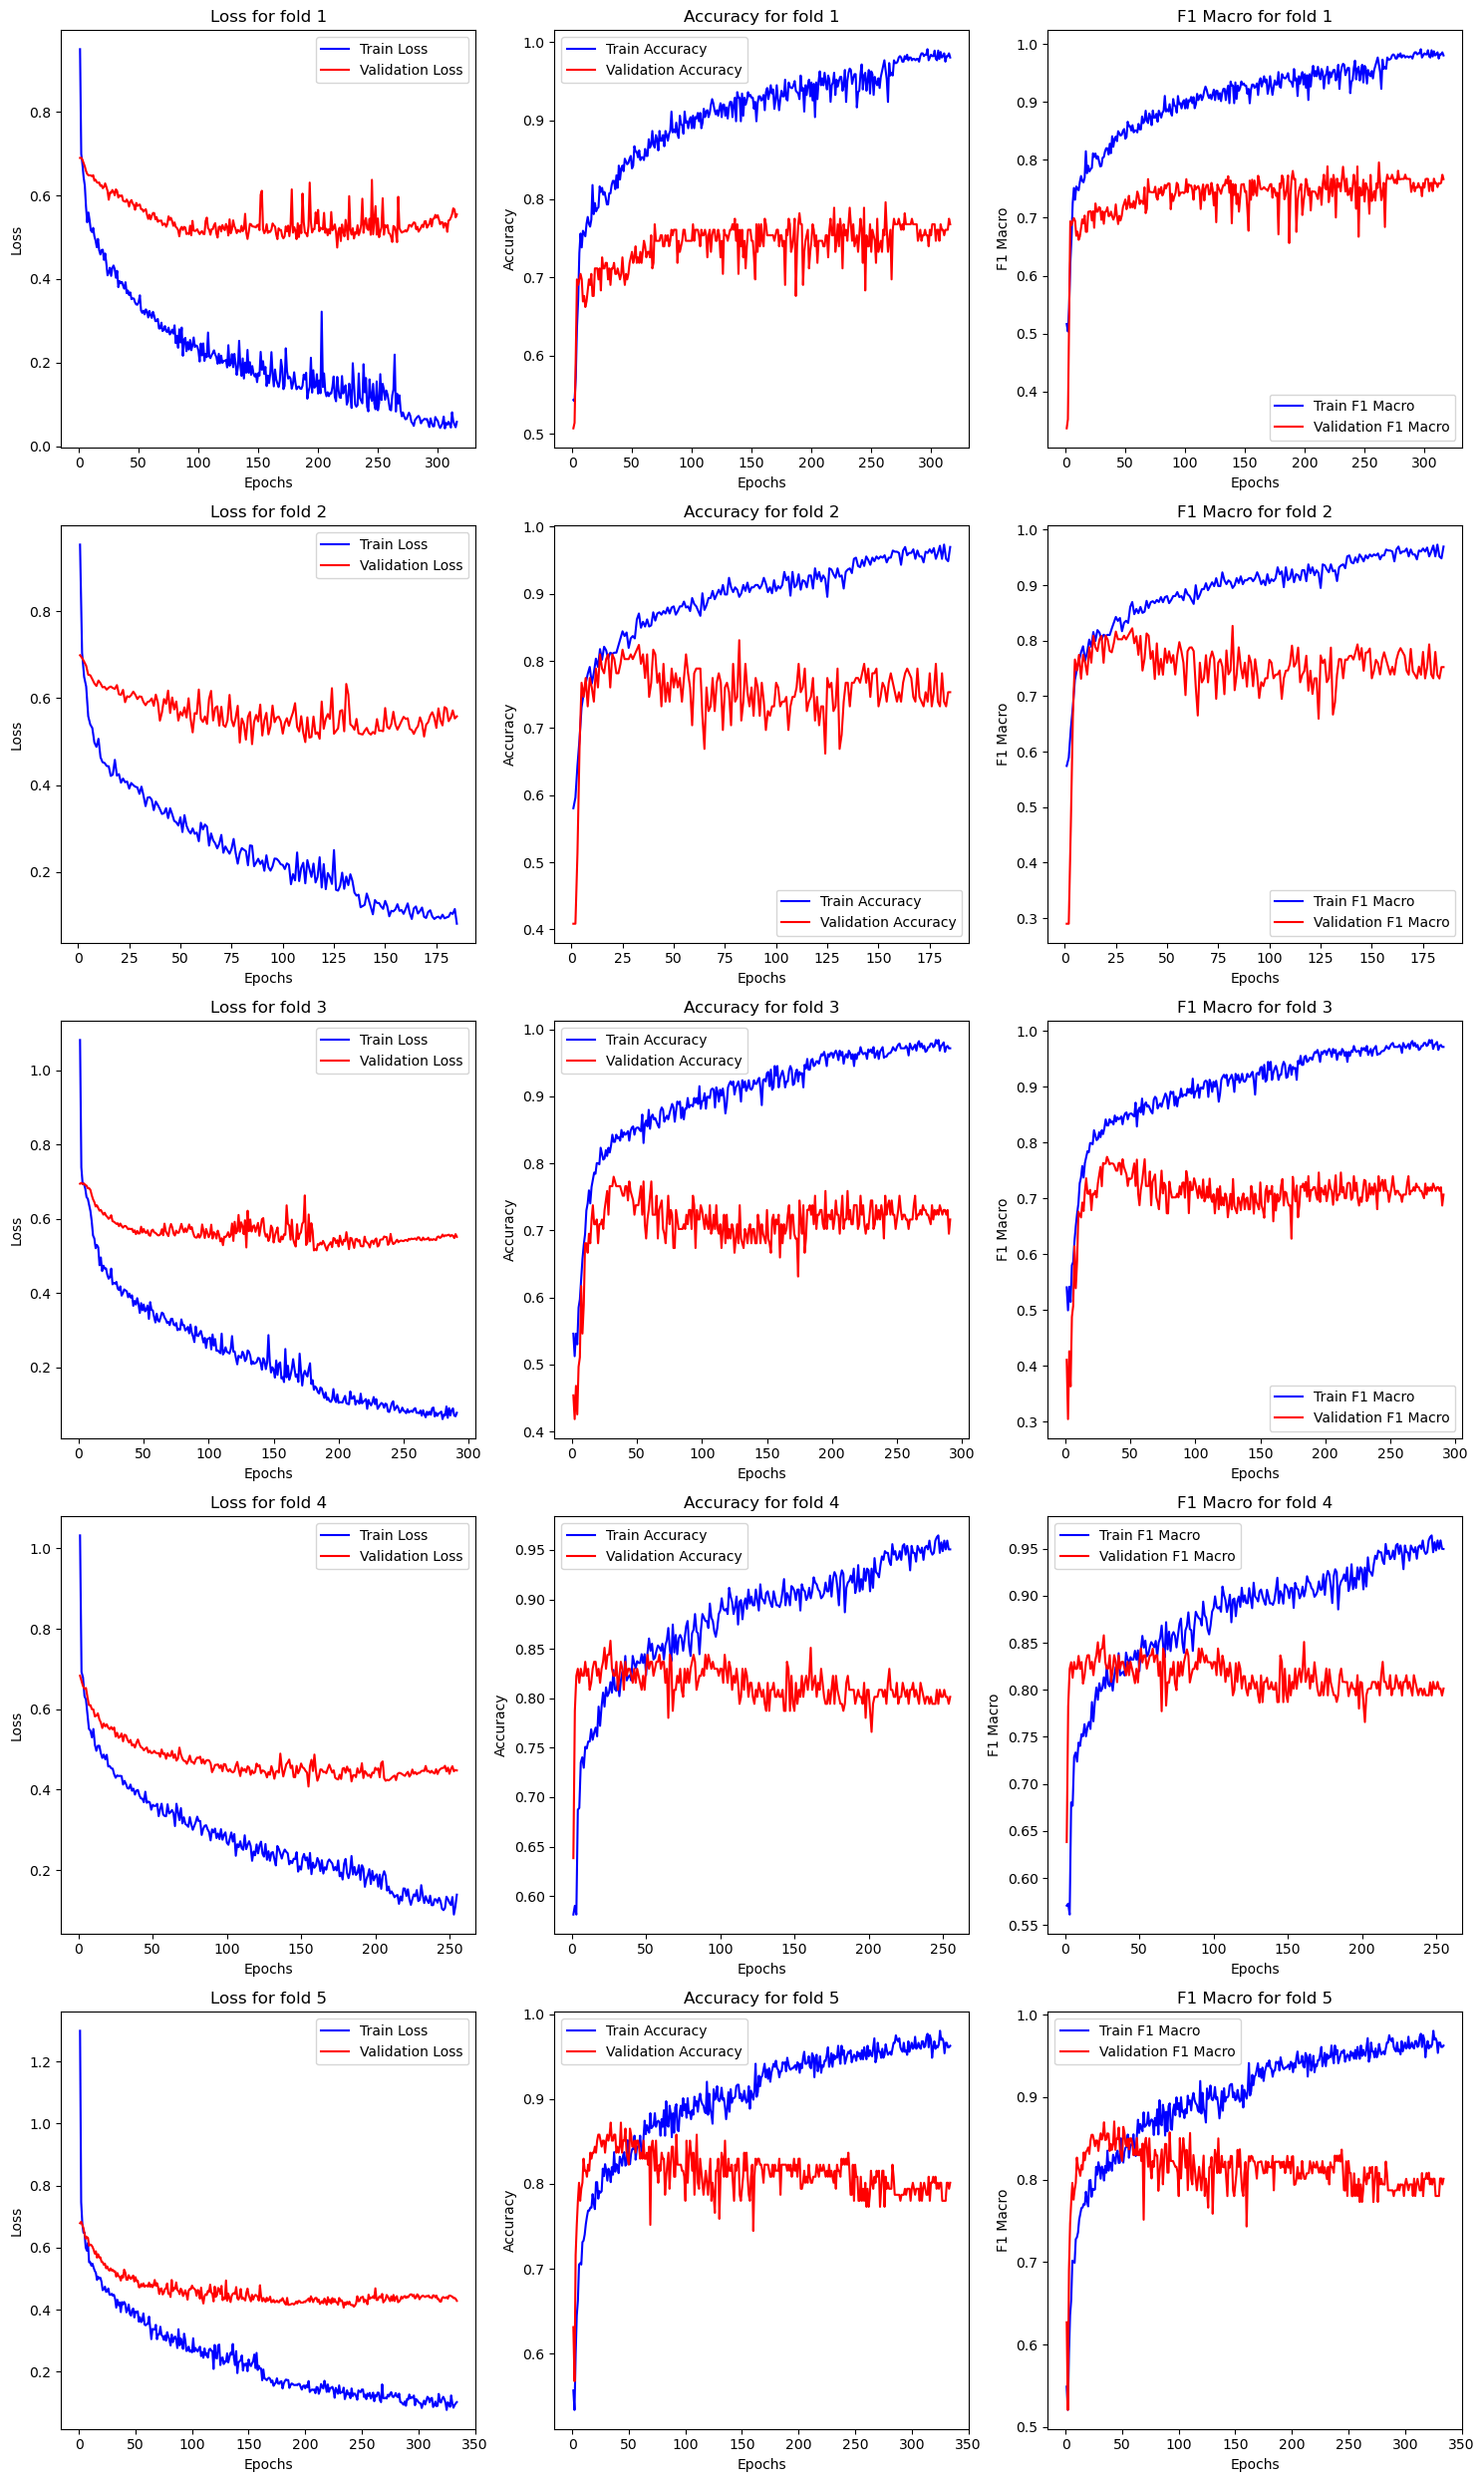

In [50]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.8481
Test ROC_AUC: 0.9712
Test F1 Macro: 0.8479
Test F1 Phen1: 0.8537
Test F1 Phen2: 0.8421
Test Recall Phen1: 0.7778
Test Recall Phen2: 0.9412


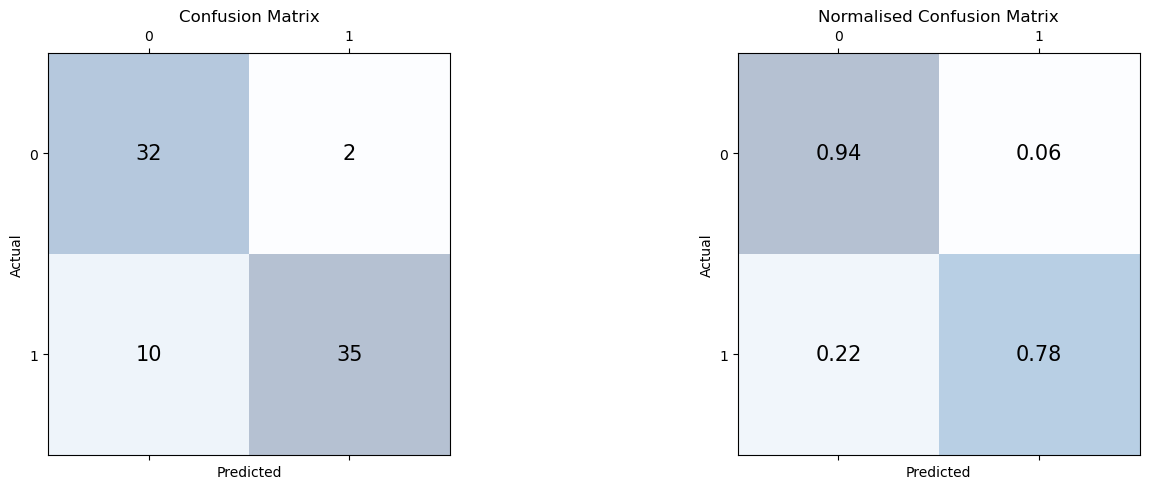

In [58]:
# load trained models
models = []
for i in range(5): 
    model = ResGAT(train_graph_data_covid[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/COVID_ResGAT_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data_covid, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')

### 2.4 COVID-19 dataset with perturbed Graph

In [40]:
# Create PyTorch Geometric Data objects for train and test data
train_graph_data_covid_pert = pytorch_graphdata(y_train, X_train, G_pert , gen_column = 'Protein', load_data = False, save_data = True, path = '/scratch/yves/DL_files/COVID_train_graph_data_pert.pkl')
test_graph_data_covid_pert = pytorch_graphdata(y_test, X_test, G_pert , gen_column = 'Protein', load_data = False, save_data = True, path = '/scratch/yves/DL_files/COVID_test_graph_data_pert.pkl')

print(f"Number of training graphs: {len(train_graph_data_covid_pert)}")
print(f"Number of test graphs: {len(test_graph_data_covid_pert)}")
print(f"Number of features: {train_graph_data_covid_pert[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data_covid_pert])}")
print(f"Is directed: {train_graph_data_covid_pert[0].is_directed()}")
print(train_graph_data_covid_pert[0])

Number of training graphs: 707
Number of test graphs: 79
Number of features: 169
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 169], edge_index=[2, 3600], y=[1])


#### 2.4.1 GCN

Cross validaton

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0005
weight_decay = 0.01 # 0.005 
batch_size = 32
layer_configs = [{"in_channels": 16, "out_channels": 16, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 128, "relu": True, "batch_norm": False, "dropout_rate": 0.5},
              {"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.5}] 

# Initialize model
num_features = train_graph_data_covid_pert[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=50, verbose=True)

# Training configurations
train_labels = y_train['group']
num_epochs = 1000
early_stopping_patience = 100
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = True
save_path = "trained_models/COVID_PERT_ResGCN"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data_covid_pert, train_labels, batch_size, num_epochs, device, save_path,
                  save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Average validation accuracy: 0.854 +/- 0.03
Average validation roc_auc: 0.922 +/- 0.02
Average validation f1_macro: 0.854 +/- 0.03
Average validation f1_phen1: 0.865 +/- 0.02
Average validation f1_phen2: 0.843 +/- 0.03
Average validation recall_phen1: 0.843 +/- 0.02
Average validation recall_phen2: 0.868 +/- 0.04
Average validation precision_phen1: 0.887 +/- 0.04
Average validation precision_phen2: 0.819 +/- 0.02


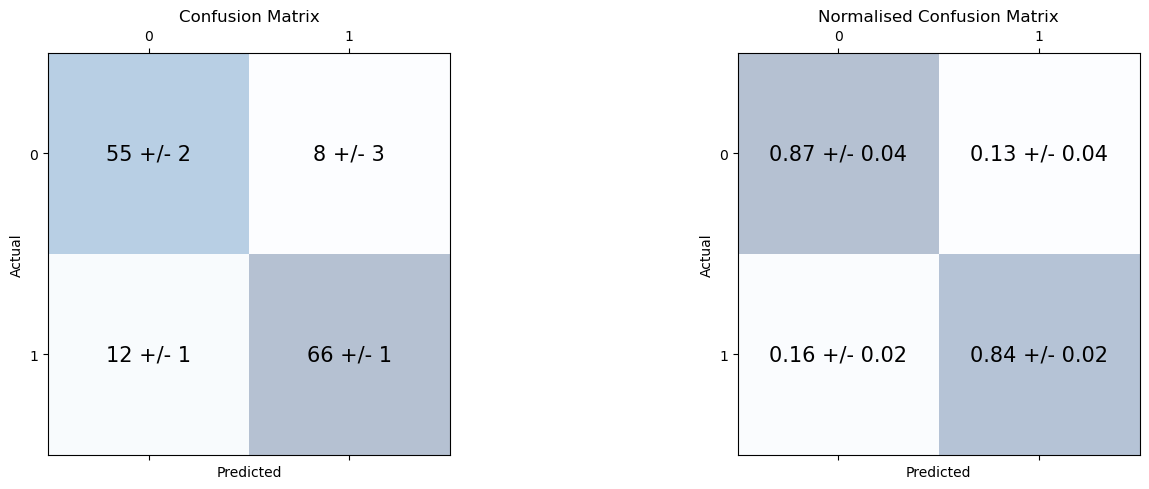

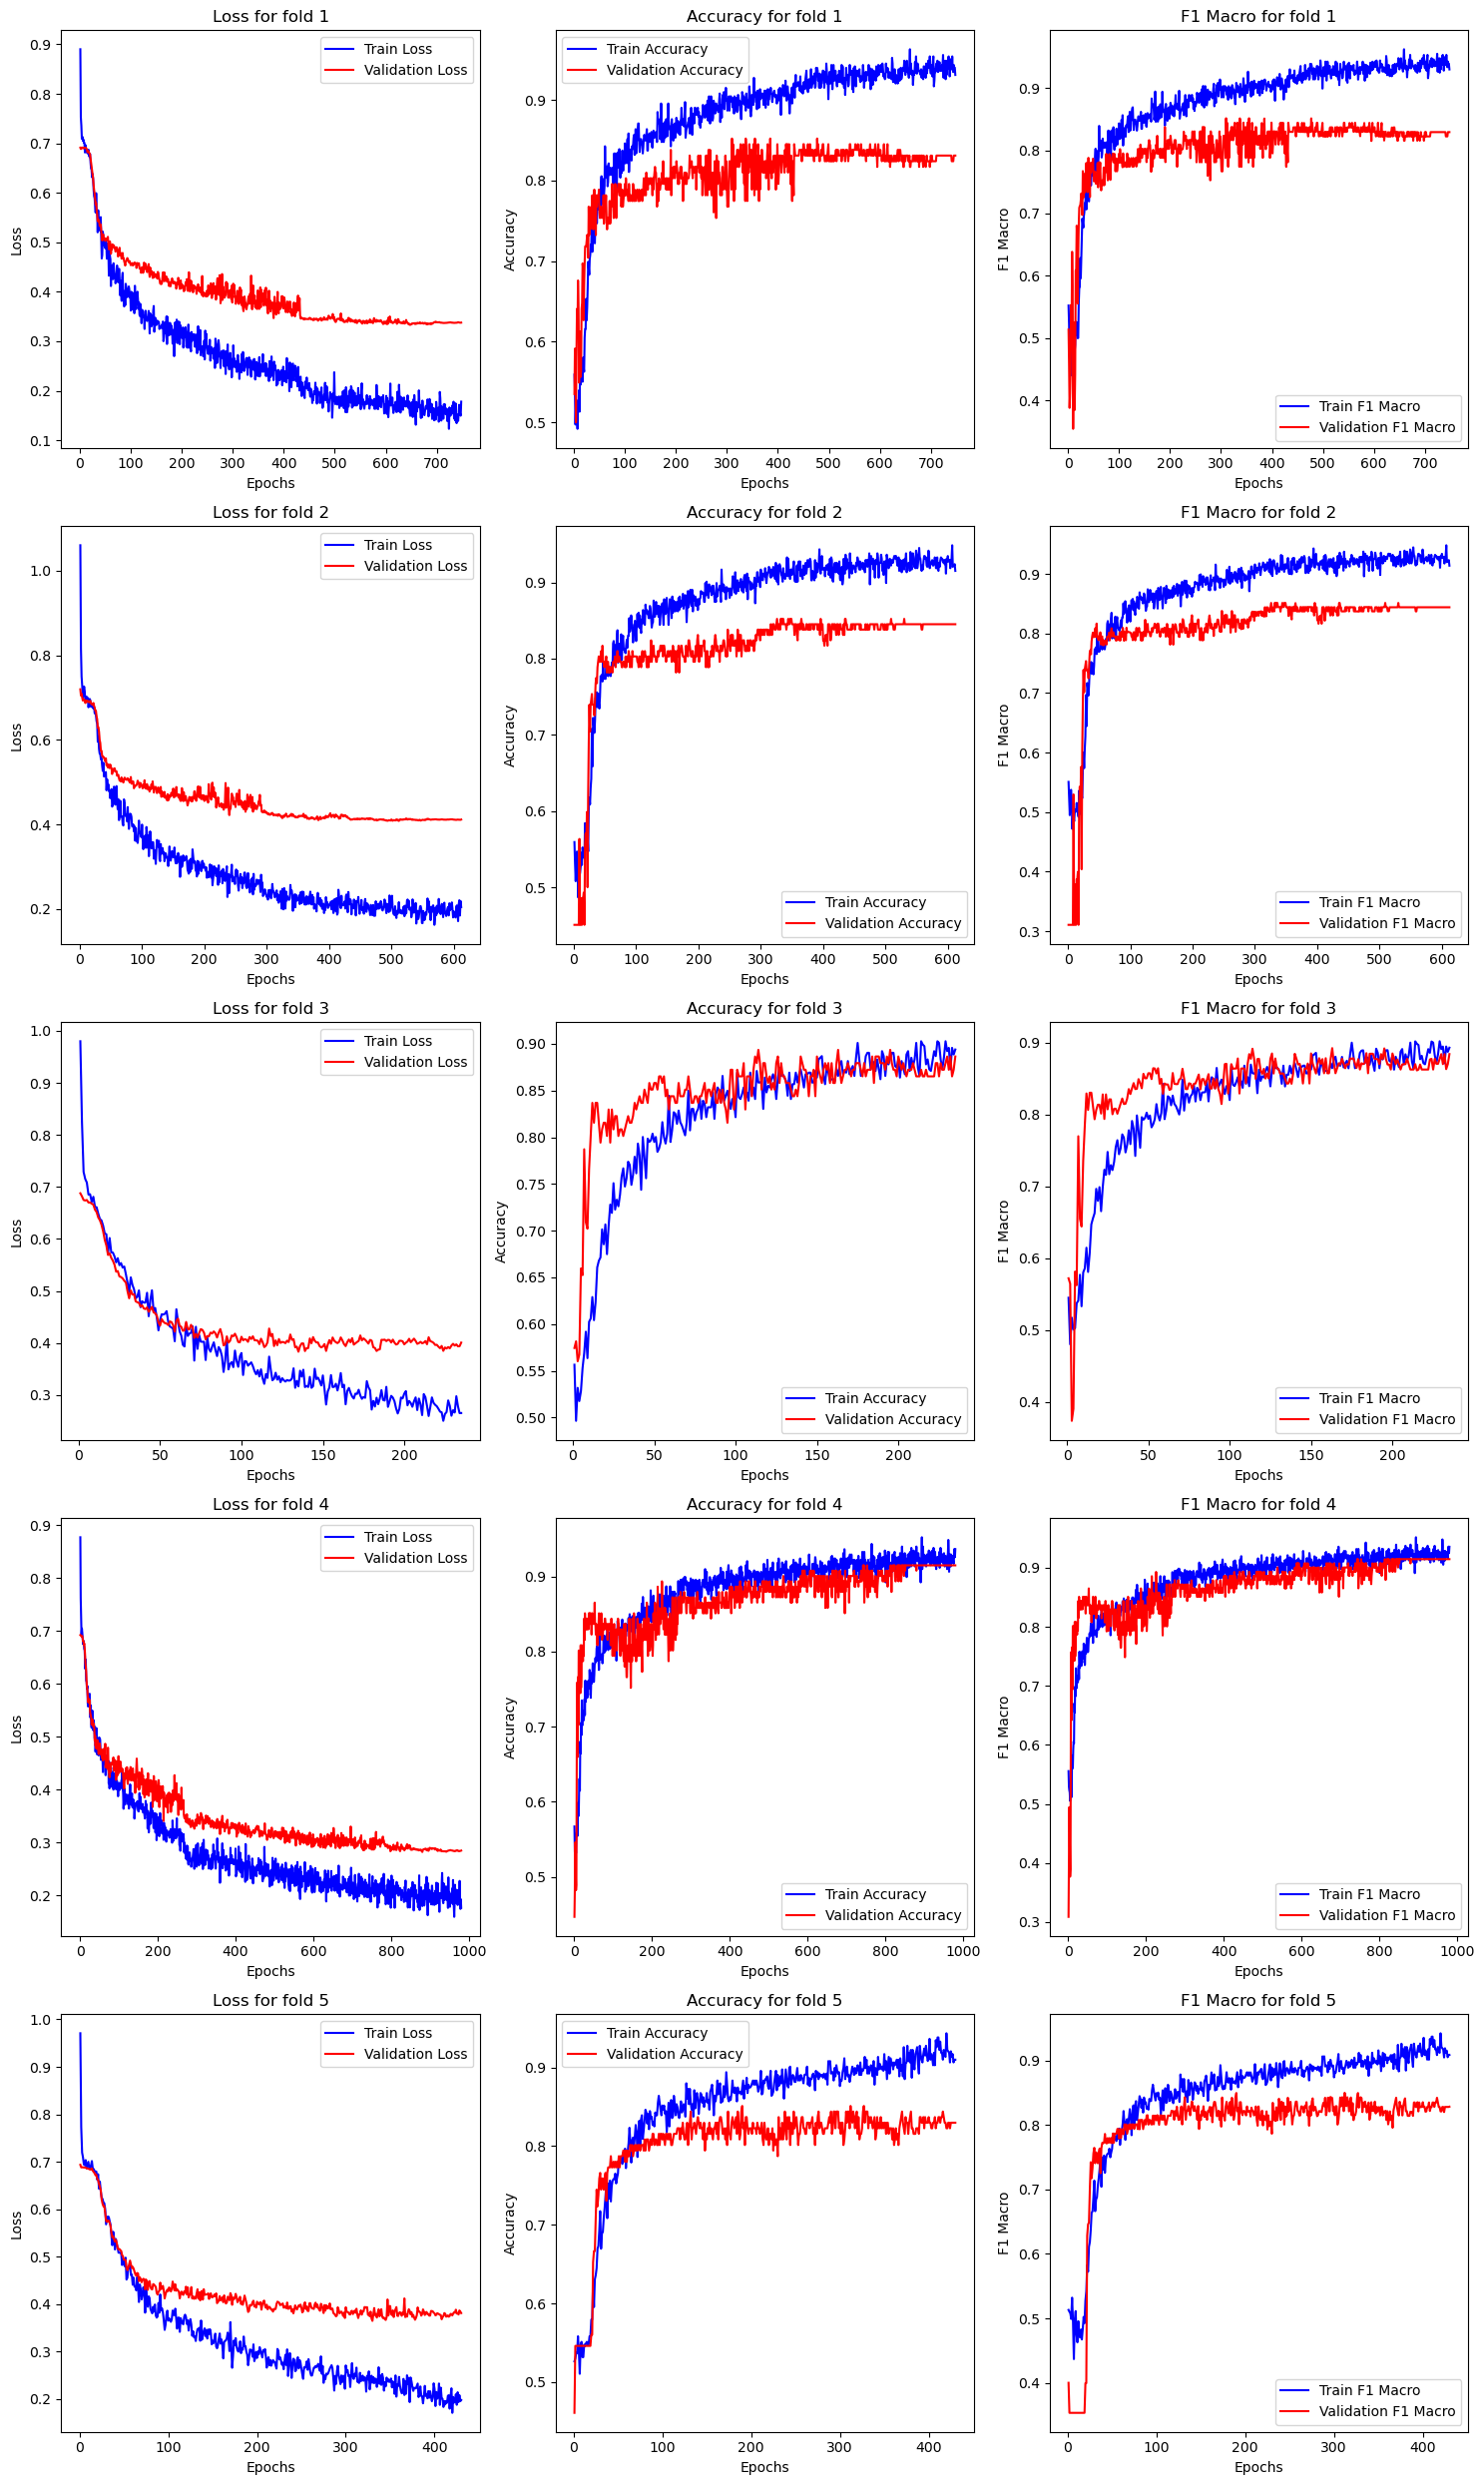

In [61]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

Test Accuracy: 0.8228
Test ROC_AUC: 0.8960
Test F1 Macro: 0.8221
Test F1 Phen1: 0.8333
Test F1 Phen2: 0.8108
Test Recall Phen1: 0.8537
Test Recall Phen2: 0.7895


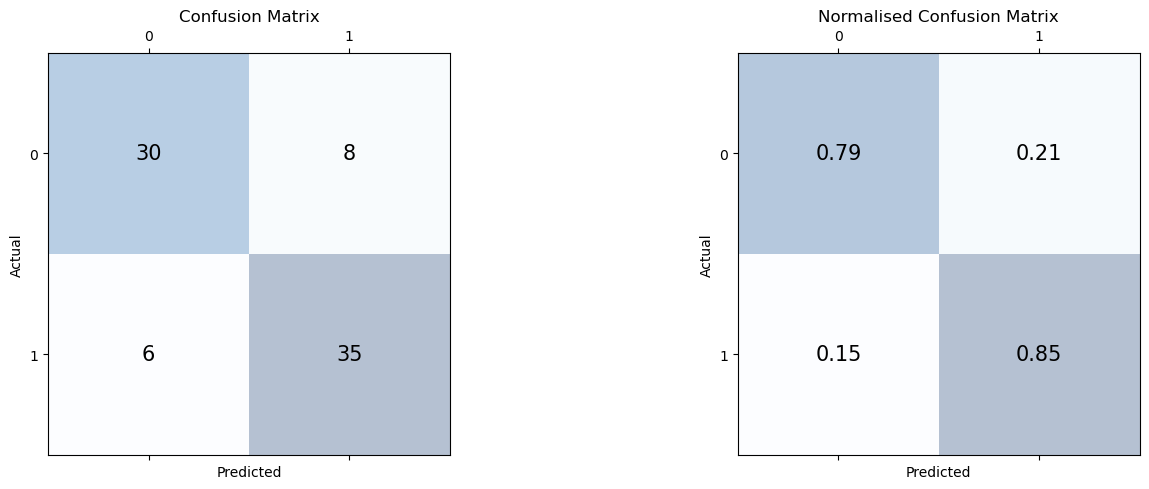

In [62]:
# load trained models
models = []
for i in range(5): 
    model = ResGCN(train_graph_data_covid_pert[0].num_features, layer_configs, mlp_config, 2).to(device)
    model.load_state_dict(torch.load(f"trained_models/COVID_PERT_ResGCN_fold_{i + 1}.pt"))
    model.eval()
    models.append(model)

# Load test data
test_loader = DataLoader(test_graph_data_covid_pert, batch_size=1)

# Ensemble prediction and probability of positive class
ensemble_preds, ensemble_prob_pos_class = test(test_loader, models, device)

# True labels for metrics calculation
true_labels = np.concatenate([batch.y.cpu().numpy() for batch in test_loader])

# Calculate confusion matrix and AUC
test_confusion_matrix = confusion_matrix(true_labels, ensemble_preds, labels=[0, 1])
test_roc_auc = roc_auc_score(true_labels, ensemble_prob_pos_class)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro = calculate_metrics(test_confusion_matrix)

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")
plot_confusion_matrix(test_confusion_matrix, use = 'test')